# Parametric-UMAP
Example notebook for UMAP transform estimation.
The Neural Network part is based on https://github.com/paoloinglese/Parametric-t-SNE/blob/master/Parametric%20UMAP%20(Keras).ipynb

See https://github.com/lmcinnes/umap/issues/40 for a discussion on how to approximate the UMAP transform function

## Create an UMAP model
Load the LSA projections and fit_transform it with UMAP

In [3]:
import umap
import numpy as np
from cartodata.operations import load_matrices_from_dumps


dump_dir = '../dumps/inria'
natures = ['articles', 'authors', 'words', 'teams', 'labs']
lsa_matrices = load_matrices_from_dumps(natures, 'lsa', dump_dir)

shapes = [matrix.shape for matrix in lsa_matrices]
umap_train = np.hstack(lsa_matrices).T

reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, init='random')
embedding = reducer.fit_transform(umap_train)

print('Input data: {}'.format(umap_train.shape))
print('Embedding: {}'.format(embedding.shape))

/Users/jonas/miniconda3/envs/keras/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../miniconda3/envs/keras/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  self.func_ir.loc))
/Users/jonas/miniconda3/envs/keras/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../miniconda3/envs/keras/

Input data: (96641, 300)
Embedding: (96641, 2)


Split the data and embedding into train and test sets for model estimation

In [4]:
from sklearn.model_selection import train_test_split
data_train, data_test, labels_train, labels_test = train_test_split(umap_train, embedding, test_size=0.20)

print(data_train.shape[0], 'train samples')
print(data_test.shape[0], 'test samples')


77312 train samples
19329 test samples


## Neural Network Estimation

Plot the list of devices available for TensorFlow

In [5]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

/Users/jonas/miniconda3/envs/keras/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/jonas/miniconda3/envs/keras/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/jonas/miniconda3/envs/keras/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/jonas/miniconda3/envs/keras/lib/python3

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15171197570736917151
]


/Users/jonas/miniconda3/envs/keras/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/jonas/miniconda3/envs/keras/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/jonas/miniconda3/envs/keras/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/jonas/miniconda3/e

Set the TensorFlow backend for Keras

In [6]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

In [7]:
%matplotlib inline
from matplotlib import pyplot as plt

import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.utils import np_utils

Using TensorFlow backend.


Define the neural network model (Using a similar topology to parametric t-SNE)

In [8]:
model = Sequential()
model.add(Dense(500, activation='relu', input_shape=(umap_train.shape[1],)))
model.add(Dense(500, activation='relu'))
model.add(Dense(2000, activation='relu'))
model.add(Dense(2))
%time model.compile(loss='mean_squared_error', optimizer='Adam')





CPU times: user 23.5 ms, sys: 772 µs, total: 24.3 ms
Wall time: 25 ms


Fit the training samples and predict the embedding for the test samples

In [9]:
batch_size = 5000
%time model.fit(data_train, labels_train, batch_size=batch_size, shuffle=False, epochs=100)
%time embedding_test = model.predict(data_test)



Epoch 1/100
77312/77312 [==============================] - 5s 61us/step - loss: 10.8554
Epoch 2/100
77312/77312 [==============================] - 4s 57us/step - loss: 5.0444
Epoch 3/100
77312/77312 [==============================] - 5s 62us/step - loss: 3.9145
Epoch 4/100
77312/77312 [==============================] - 5s 61us/step - loss: 3.3019
Epoch 5/100
77312/77312 [==============================] - 5s 61us/step - loss: 2.8766
Epoch 6/100
77312/77312 [==============================] - 5s 61us/step - loss: 2.5573
Epoch 7/100
77312/77312 [==============================] - 5s 61us/step - loss: 2.3040
Epoch 8/100
77312/77312 [==============================] - 5s 61us/step - loss: 2.0964
Epoch 9/100
77312/77312 [==============================] - 5s 61us/step - loss: 1.9188
Epoch 10/100
77312/77312 [==============================] - 5s 62us/step - loss: 1.7634
Epoch 11/100
77312/77312 [==============================] - 5s 63us/step - loss: 1.6313
Epoch 12/100
77312/77312 [============

77312/77312 [==============================] - 6s 75us/step - loss: 0.1874
Epoch 90/100
77312/77312 [==============================] - 6s 78us/step - loss: 0.1908
Epoch 91/100
77312/77312 [==============================] - 6s 75us/step - loss: 0.1970
Epoch 92/100
77312/77312 [==============================] - 6s 74us/step - loss: 0.2054
Epoch 93/100
77312/77312 [==============================] - 6s 75us/step - loss: 0.2194
Epoch 94/100
77312/77312 [==============================] - 6s 75us/step - loss: 0.2410
Epoch 95/100
77312/77312 [==============================] - 6s 76us/step - loss: 0.2634
Epoch 96/100
77312/77312 [==============================] - 7s 88us/step - loss: 0.2913
Epoch 97/100
77312/77312 [==============================] - 11s 140us/step - loss: 0.3291
Epoch 98/100
77312/77312 [==============================] - 9s 113us/step - loss: 0.3788
Epoch 99/100
77312/77312 [==============================] - 6s 83us/step - loss: 0.4292
Epoch 100/100
77312/77312 [===============

Plot the embedding for the test samples from UMAP and NN

Text(0.5, 1.0, 'UMAP (red) & NN predicted (blue) embedding - test samples')

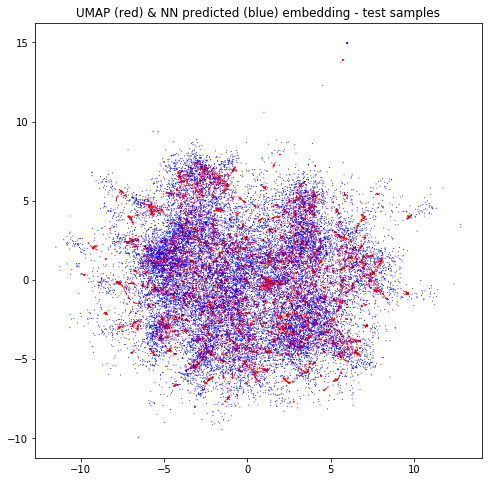

In [10]:
fig = plt.figure(figsize=(8, 8))
plt.scatter(labels_test[:,0], labels_test[:,1], marker='o', s=1, edgecolor='', c='red')
plt.scatter(embedding_test[:,0], embedding_test[:,1], marker='o', s=1, edgecolor='', c='blue')
plt.title("UMAP (red) & NN predicted (blue) embedding - test samples")

### Mean Absolute Error

In [11]:
print('Mean Absolute Error: {}'.format(np.linalg.norm(labels_test - embedding_test, axis=1).mean()))

Mean Absolute Error: 1.611573338508606


### Save and load Neural Network model

In [12]:
from keras.models import load_model

model.save('trained_nn.h5')  # creates a HDF5 file 'my_model.h5'
del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
%time model = load_model('trained_nn.h5')

CPU times: user 828 ms, sys: 54.3 ms, total: 882 ms
Wall time: 901 ms


Make prediction on new random data point

In [13]:
idx = np.random.randint(data_test.shape[0], size=1)
%time out = model.predict(data_test[idx, :])

print('Predicted position: {}'.format(out))
print('UMAP position: {}'.format(labels_test[idx, :]))

CPU times: user 42.1 ms, sys: 2.56 ms, total: 44.7 ms
Wall time: 46.6 ms
Predicted position: [[-0.3589281  1.8186592]]
UMAP position: [[0.46999702 1.6283325 ]]


## Nearest Neighbors barycentric estimation

In [14]:
import nmslib

nms = nmslib.init(method='hnsw', space='cosinesimil')
nms.addDataPointBatch(data_train)
nms.createIndex(print_progress=True)

Get 50 nearest neighbors for test data

In [15]:
neighbors = nms.knnQueryBatch(data_test, k=50)

In [16]:
def neighbors_to_pos(neighbors):
    barys = []
    for ids, distances in neighbors:
        weights = (1 - distances)
        weights = weights / weights.sum()
        bary = weights.dot(labels_train[ids])
        barys.append(bary)
    return np.array(barys)
        
knn_embedding_test = neighbors_to_pos(neighbors)

Plot the embedding for the test samples from UMAP and kNN method

Text(0.5, 1.0, 'UMAP (red) & kNN predicted (blue) embedding - test samples')

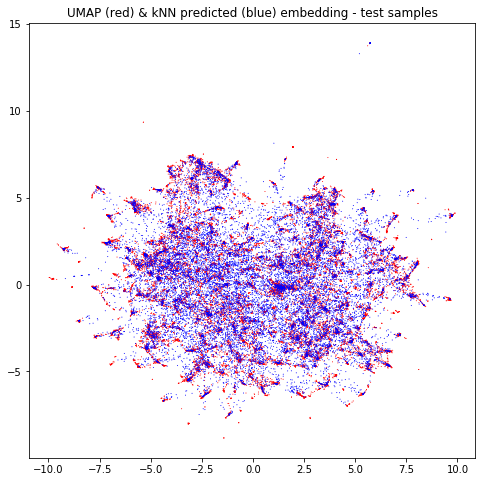

In [17]:
fig = plt.figure(figsize=(8, 8))
plt.scatter(labels_test[:,0], labels_test[:,1], marker='o', s=1, edgecolor='', c='red')
plt.scatter(knn_embedding_test[:,0], knn_embedding_test[:,1], marker='o', s=1, edgecolor='', c='blue')
plt.title("UMAP (red) & kNN predicted (blue) embedding - test samples")

### Mean Absolute Error

In [18]:
print('Mean Absolute Error: {}'.format(np.linalg.norm(labels_test - knn_embedding_test, axis=1).mean()))

Mean Absolute Error: 1.0033143758773804


### Parameter optimization for k

In [19]:
scores = []
for k in range(5, 105, 5):
    print('Estimating for k = {}'.format(k))
    neighbors = nms.knnQueryBatch(data_test, k=k)
    knn_embedding_test = neighbors_to_pos(neighbors)
    mae = np.linalg.norm(labels_test - knn_embedding_test, axis=1).mean()
    scores.append((k, mae))
scores = np.array(scores, dtype=[('k', 'i4'), ('mae', 'f4')])

Estimating for k = 5
Estimating for k = 10
Estimating for k = 15
Estimating for k = 20
Estimating for k = 25
Estimating for k = 30
Estimating for k = 35
Estimating for k = 40
Estimating for k = 45
Estimating for k = 50
Estimating for k = 55
Estimating for k = 60
Estimating for k = 65
Estimating for k = 70
Estimating for k = 75
Estimating for k = 80
Estimating for k = 85
Estimating for k = 90
Estimating for k = 95
Estimating for k = 100


Text(0.5, 1.0, 'Mean Absolute Error for kNN estimation')

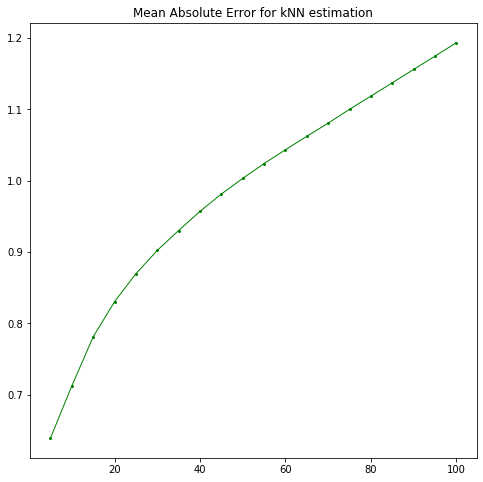

In [20]:
fig = plt.figure(figsize=(8, 8))
plt.plot('k', 'mae', 'go-', data=scores, linewidth=1, markersize=2)
plt.title("Mean Absolute Error for kNN estimation")

### Save and load kNN model

In [21]:
nms.saveIndex('trained_knn', save_data=True)
del nms

nms = nmslib.init(method='hnsw', space='cosinesimil')
%time nms.loadIndex('trained_knn', load_data=True)

CPU times: user 75.4 ms, sys: 77.8 ms, total: 153 ms
Wall time: 217 ms


Make prediction on new random data point

In [23]:
idx = np.random.randint(data_test.shape[0], size=1)
%time neighbors = nms.knnQueryBatch(data_test[idx, :], k=5)
out = neighbors_to_pos(neighbors)

print('Predicted position: {}'.format(out))
print('UMAP position: {}'.format(labels_test[idx, :]))

CPU times: user 598 µs, sys: 858 µs, total: 1.46 ms
Wall time: 1.2 ms
Predicted position: [[-2.1555843  1.8558383]]
UMAP position: [[-2.1388948  1.8303642]]
